In [145]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from amplpy import AMPL, ampl_notebook

In [146]:
# Create .dat
df = pd.read_csv("top10_sp100_companies.csv")

df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.date

# Pivot table
price_df = df.pivot(index="Date", columns="Ticker", values="Close")
price_df = price_df.sort_index()

# Daily returns
returns_df = price_df.pct_change().dropna()

# Add mean as benchmark
returns_df["BENCHMARK"] = returns_df.mean(axis=1)

# Save as a .dat
with open("returns_data.dat", "w") as f:
    tickers = list(returns_df.columns.difference(["BENCHMARK"]))
    f.write(f"set S := {' '.join(tickers)};\n")
    f.write(f"set T := {' '.join(['t' + str(i) for i in range(len(returns_df))])};\n\n")
    
    f.write("param r :\n")
    f.write("       " + ' '.join(['t' + str(i) for i in range(len(returns_df))]) + " :=\n")
    
    for ticker in tickers:
        f.write(f"{ticker} " + ' '.join(f"{returns_df.iloc[i][ticker]:.6f}" for i in range(len(returns_df))) + "\n")
    f.write(";\n\n")
    
    f.write("param b :=\n")
    for i in range(len(returns_df)):
        f.write(f"t{i} {returns_df.iloc[i]['BENCHMARK']:.6f}\n")
    f.write(";\n")

In [147]:
# Setup AMPL
ampl = ampl_notebook(
    modules=["cbc", "gurobi", "cplex"],
    license_uuid="18173b93-c75d-4d63-a2f4-38b78354b605")

ampl.set_option("solver", "cplex")
ampl.read("index_tracking.mod")
ampl.read_data("returns_data.dat")

# Iterate q values and get results
results = []
for q_val in range(1, 11):
    ampl.param["q"] = q_val
    ampl.solve()

    p_series = ampl.get_variable("p").to_pandas().sort_index()
    b_series = ampl.get_parameter("b").to_pandas().sort_index()

    p = p_series.values
    b = b_series.values
    # print(type(p_series))
    # print(type(b_series))
    # print(p_series)
    # print(b_series)
    df_combined = pd.concat([p_series, b_series], axis=1)
    # print(df_combined)

    # df_returns = pd.concat([
    #         pd.Series(p_series, name="portfolio"),
    #         pd.Series(b_series, name="benchmark")
    #     ], axis=1).dropna()
    # print(f"q = {q_val}, p = {p}, b = {b}")
    # print(len(p), len(b))

    # corr = np.corrcoef(p, b)[0, 1]
    df_combined = pd.concat([p_series, b_series], axis=1)
    corr = df_combined.corr().iloc[0, 1]
    print(f"Correlation: {corr:.4f}")
    te = np.sqrt(np.mean((p - b)**2))
    results.append((q_val, corr, te))

    selected_stocks = ampl.get_variable("x").to_dict()
    weights = ampl.get_variable("w").to_dict()

    print("Selected Stocks:")
    for stock, chosen in selected_stocks.items():
        if chosen > 0.5:
            print(f"{stock} - weight: {weights[stock]:.4f}")

df_results = pd.DataFrame(results, columns=["q", "Correlation", "TrackingError"])
print(df_results)

Licensed to AMPL Academic Community Edition License for <x23430133@student.ncirl.ie>.
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.07544379658
14 simplex iterations
Correlation: 0.6906
Selected Stocks:
V - weight: 1.0000
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.03062159614
147 simplex iterations
60 branching nodes
Correlation: 0.8728
Selected Stocks:
MSFT - weight: 0.4937
V - weight: 0.5063
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.02032648408
351 simplex iterations
149 branching nodes
Correlation: 0.9264
Selected Stocks:
META - weight: 0.1576
MSFT - weight: 0.3579
V - weight: 0.4845
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.01277919873
543 simplex iterations
216 branching nodes
Correlation: 0.9435
Selected Stocks:
DIS - weight: 0.2109
JNJ - weight: 0.2871
META - weight: 0.1603
MSFT - weight: 0.3417
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.007837820071
582 simplex iterations
226 branching nodes
Correlation: 0.9673
Sel

Portfolio Returns:
         p.val
t0   -0.004903
t1    0.008382
t10  -0.000182
t100 -0.006463
t101  0.016361
...        ...
t95  -0.007805
t96  -0.007737
t97  -0.004647
t98   0.009299
t99  -0.014454

[750 rows x 1 columns]
Benchmark Returns:
             b
t0   -0.004903
t1    0.008382
t10  -0.000182
t100 -0.006463
t101  0.016361
...        ...
t95  -0.007806
t96  -0.007737
t97  -0.004646
t98   0.009299
t99  -0.014454

[750 rows x 1 columns]


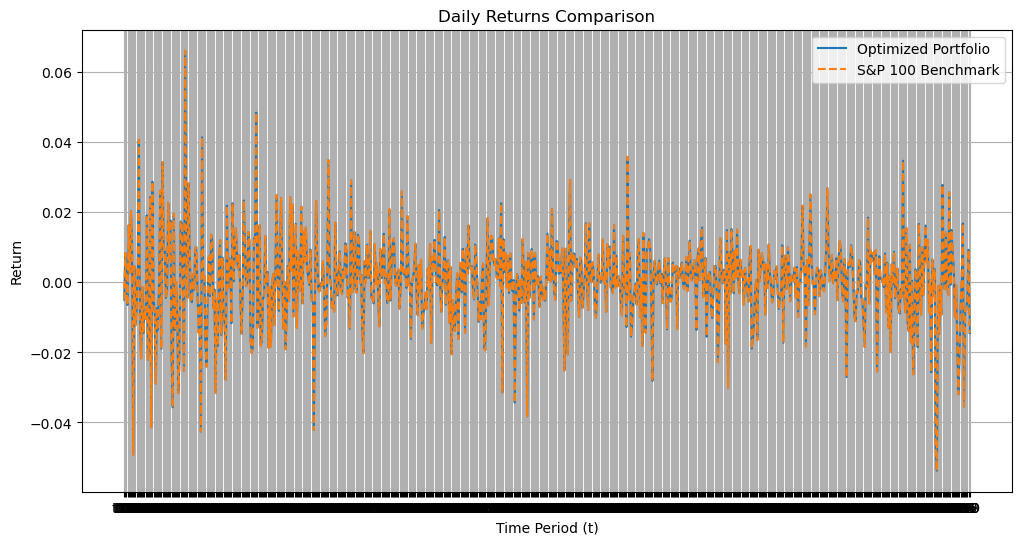

In [148]:
# Plot portfolio and benchmark returns
p = ampl.get_variable("p").to_pandas()
print("Portfolio Returns:")
print(p)
b = ampl.get_parameter("b").to_pandas()
print("Benchmark Returns:")
print(b)

plt.figure(figsize=(12,6))
plt.plot(p.index, p.values, label="Optimized Portfolio")
plt.plot(b.index, b.values, label="S&P 100 Benchmark", linestyle="--")
plt.title("Daily Returns Comparison")
plt.xlabel("Time Period (t)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


In [149]:
p_series = ampl.get_variable("p").to_pandas().sort_index()
b_series = ampl.get_parameter("b").to_pandas().sort_index()

p = p_series.values
b = b_series.values

# Correlation
# correlation = np.corrcoef(p_returns, b_returns)[0, 1]
df_combined = pd.concat([p_series, b_series], axis=1)
corr = df_combined.corr().iloc[0, 1]
print(f"Correlation: {corr:.4f}")

# Tracking Error
tracking_error = np.sqrt(np.mean((p - b) ** 2))

# print(f"Correlation: {correlation:.4f}")
print(f"Tracking Error: {tracking_error:.4f}")


Correlation: 1.0000
Tracking Error: 0.0000


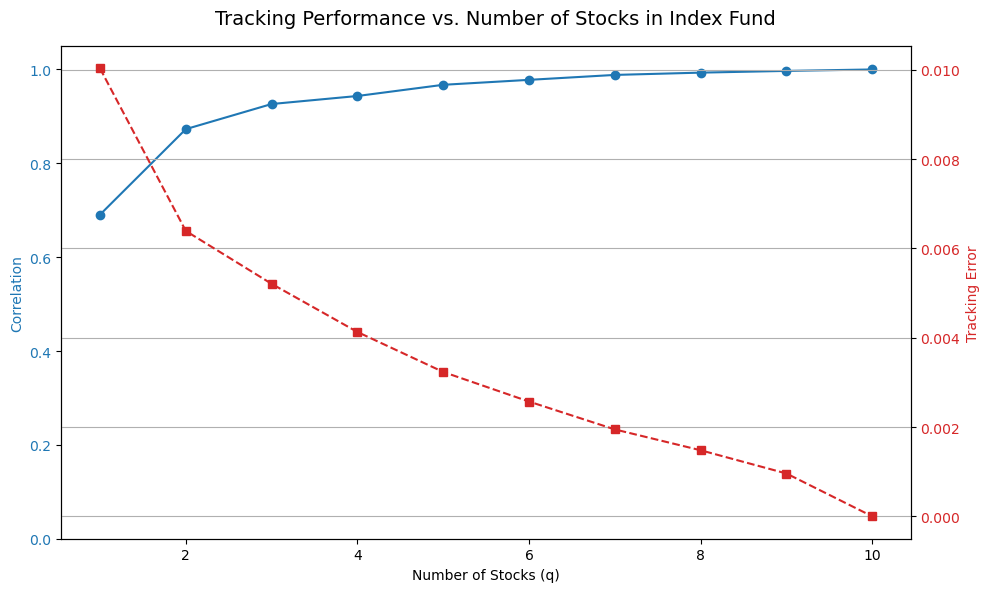

In [150]:
# Plot correlation and tracking error vs. q
fig, ax1 = plt.subplots(figsize=(10, 6))

# Correlation
color = 'tab:blue'
ax1.set_xlabel('Number of Stocks (q)')
ax1.set_ylabel('Correlation', color=color)
ax1.plot(df_results["q"], df_results["Correlation"], marker='o', color=color, label="Correlation")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.05)

# Tracking
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
ax2.plot(df_results["q"], df_results["TrackingError"], marker='s', linestyle='--', color=color, label="Tracking Error")
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Tracking Performance vs. Number of Stocks in Index Fund", fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()
